## Predicting Hotel Booking Cancellations using a Voting Classifier
### Notebook 1: Data Preprocessing and EDA
#### Amro Shanshal

This booking website has a dataset of hotel cancellations and would like a data scientist to build a classification model that predicts future cancellations. They have provided me with a number of metrics/features that are relevant to the problem. The 32 features they provided are within the following buckets:

- Hotel type, room and stay
- previous stays
- location
- booking logistics
- Payment
- customer

I built a solution that includes data cleaning, Explartory Data Analysis (EDA), feature engineering, model building and evaluation

Importing necessary libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
# Minmax scaler
from sklearn.preprocessing import MinMaxScaler
import datetime


## Step 1: Examine data and Explaratory Data Analysis (EDA)

In [2]:
# import training data
df = pd.read_csv("hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


metadata for ambiguous column names:

-  <b>lead_time </b>: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
-  <b>stays_in_weekend_nights</b>: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
-  <b>meal</b>: Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal
-  <b>country</b>: Country of origin. Categories are represented in the ISO 3155–3:2013 format
-  <b>market_segment</b>: Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
-  <b>distribution_channel</b>: Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”
-  <b>booking_changes</b>: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS
-  <b>adr</b>: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

In [5]:
#examine columns, nulls and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

There are some nulls to deal with in the country, agent, company columns

### Explaratory Data Analysis (EDA)

Presetting the plotting functions

In [3]:
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

In [8]:
# value count of variable 'hotel'
df['hotel'].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

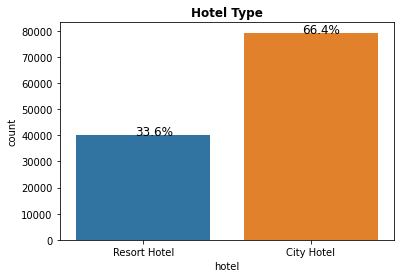

In [7]:
# countplot based on hotel type  
plt.title('Hotel Type', weight='bold')
ax= sns.countplot('hotel', data=df)
without_hue(ax,df['hotel'])

- City hotels are the majority 

Text(0.5, 1.0, 'Canceled Situation')

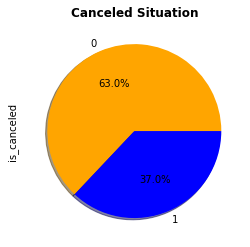

In [8]:
#Piechart based on cancel situation column 
cols = ['orange','blue']
df['is_canceled'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, colors=cols)
plt.title('Canceled Situation', weight='bold')

- This gives me an idea about my target variable (is_canceled). I do see a class imbalance problem, which is common in churn problems

<AxesSubplot:title={'center':'Hotel Type vs Cancelation'}, xlabel='count', ylabel='hotel'>

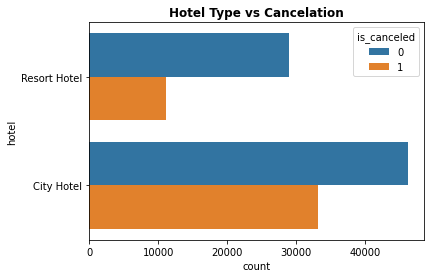

In [9]:
#countplot based on hotel type and cancel situation column
plt.title('Hotel Type vs Cancelation', weight='bold')
sns.countplot(y='hotel', hue='is_canceled', data=df)

In [11]:
#I want to see the summary statistics to understand outliers, and any unusual behavior 
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


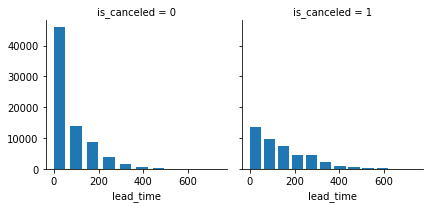

In [12]:
grid = sns.FacetGrid(df, col='is_canceled')
grid.map(plt.hist, 'lead_time', width=50)
grid.add_legend()

- Maximum cancelations occur when the booking is made 60-80 days before the checkin date. I also see that the longer the lead_time, lower is the cancelation

Text(0.5, 1.0, 'Arrival Month')

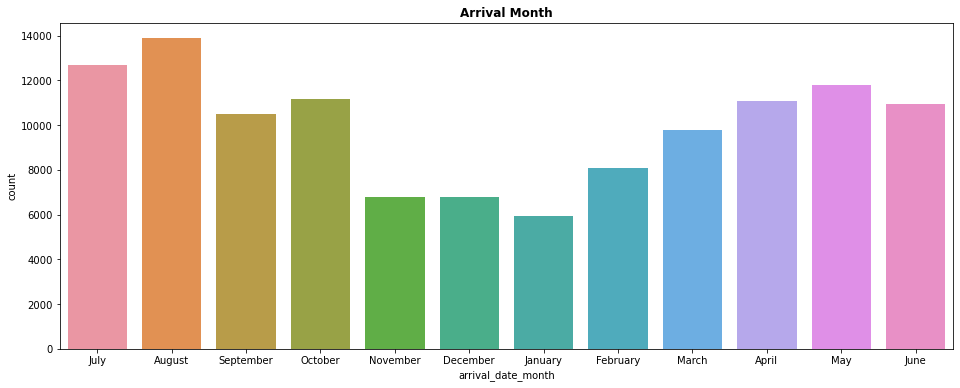

In [15]:
#countplot based on arrival_date_month column
plt.figure(figsize=(16,6))
sns.countplot(x='arrival_date_month',data=df,)
plt.title('Arrival Month', weight='bold')

- The busiest months are July, August (in the summer), and the months lagging and leading summer 

Now I will examine how the relationship between lead time and arrival month

Text(0.5, 1.0, 'Lead Time vs Arrival Month')

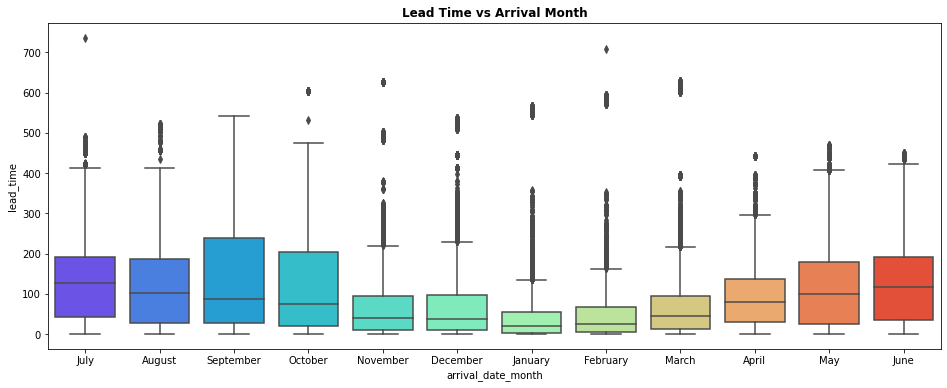

In [13]:
#boxplot based on arrival_date_month and lead_time column
plt.figure(figsize=(16,6))
sns.boxplot(x='arrival_date_month',y='lead_time',data=df,palette='rainbow')
plt.title('Lead Time vs Arrival Month', weight='bold')

- Lead time of bookings is higher in the summer and months lead up to the summer 

Text(0.5, 1.0, 'Lead Time vs Hotel Type ')

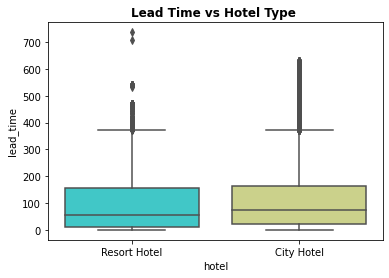

In [14]:
#boxplot based on hotel type and lead_time column
sns.boxplot(x='hotel',y='lead_time',data=df,palette='rainbow')
plt.title('Lead Time vs Hotel Type ', weight='bold')

- City hotels have a higher lead time. I am assuming this is because cities are busier than resort areas so customers book earlier

In [3]:
# I will encode the months for further analysis

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
         'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
    
    #Create new column month with int value
df['month'] = df['arrival_date_month'].map(d)

In [4]:
df.rename(columns={'arrival_date_year': 'year', 
                       'arrival_date_day_of_month': 'day'}, inplace=True)
df['arrival_date'] = pd.to_datetime(df[['year', 'month' , 'day']])

<AxesSubplot:xlabel='stays_in_weekend_nights', ylabel='Density'>

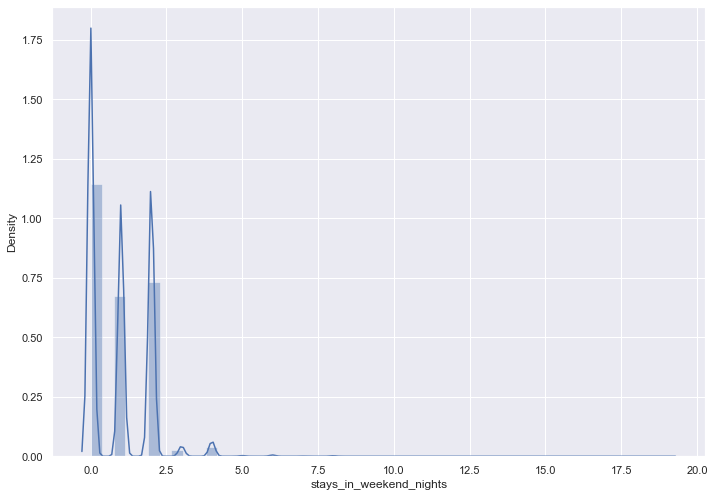

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['stays_in_weekend_nights'], hist = True)

- It makes sense that many of the guests are staying less than 2 weekend nights, but there are customers with an aggregate weekend nights that's high

<AxesSubplot:xlabel='stays_in_week_nights', ylabel='Density'>

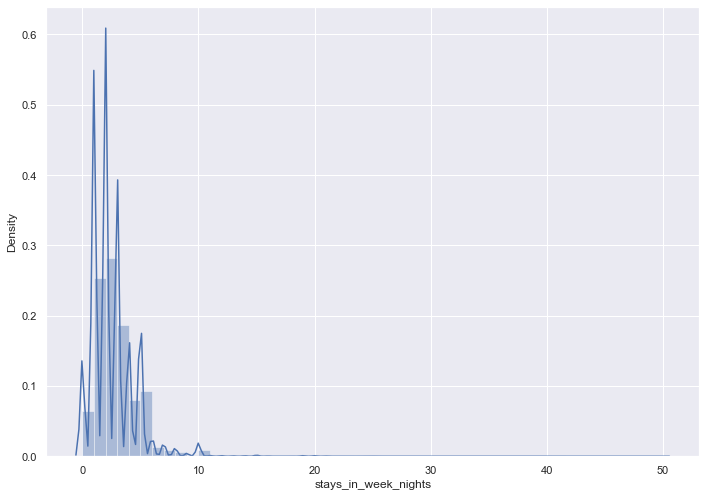

In [20]:
sns.distplot(df['stays_in_week_nights'], hist = True)

I will do feature engineering to combine week and weekend nights

In [5]:
df['stays_total']= df['stays_in_week_nights']+df['stays_in_weekend_nights']

<AxesSubplot:xlabel='stays_total', ylabel='Density'>

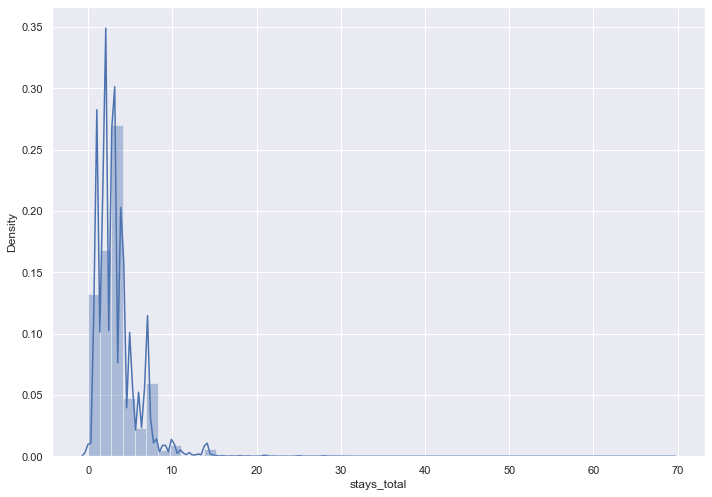

In [23]:
sns.distplot(df['stays_total'], hist = True)

In [24]:
df['stays_total'].describe()

count    119390.000000
mean          3.427900
std           2.557439
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          69.000000
Name: stays_total, dtype: float64

<AxesSubplot:xlabel='stays_total', ylabel='hotel'>

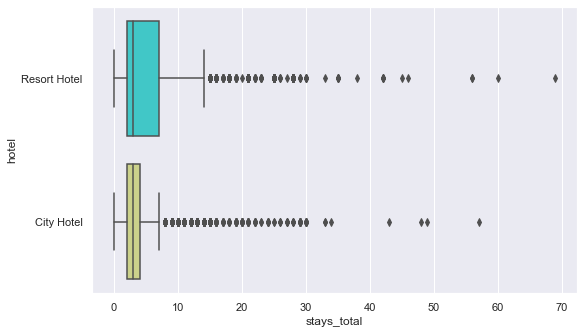

In [30]:
sns.set(rc={'figure.figsize':(8.7,5.27)})
sns.boxplot(x='stays_total',y='hotel',data=df,palette='rainbow')

- Resort hotels have longer stays than city hotels. Another observation to note is that the average city hotel stays is around 4-5 days which could also indicate that some business trips are in this category 

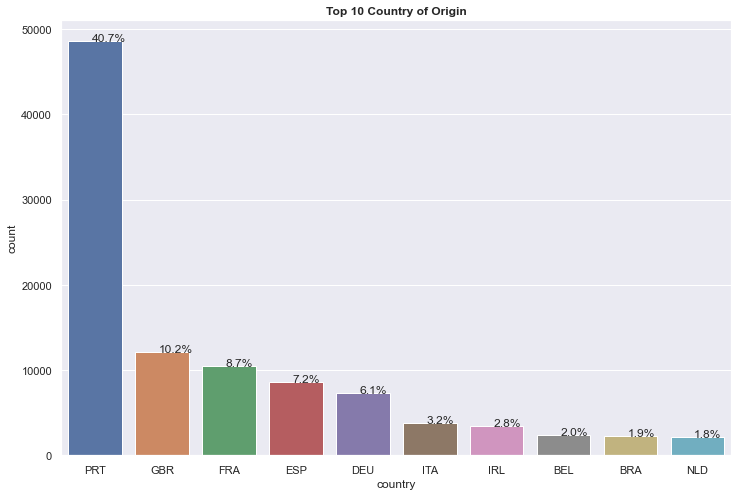

In [31]:
#boxplot based on country column
plt.figure(figsize=(12,8))
plt.title('Top 10 Country of Origin', weight='bold')
ax= sns.countplot(x='country', data=df, 
              order=pd.value_counts(df['country']).iloc[:10].index)
without_hue(ax,df['country'])

- 40.7% of the data we have comes from bookings in Portugal

Text(0.5, 1.0, 'Canceled Situation vs Deposit Type ')

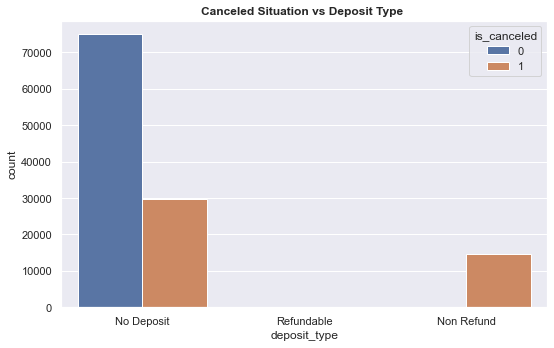

In [32]:
#countplot based on Canceled Situation and Deposit Type column
sns.countplot('deposit_type', hue='is_canceled', data=df)
 
plt.title('Canceled Situation vs Deposit Type ', weight='bold')

- It makes sense that the majority of cancellations are ones requiring no deposit. This feature may have a strong predictive power in my model because people are more inclined to cancel when they have nothing to lose

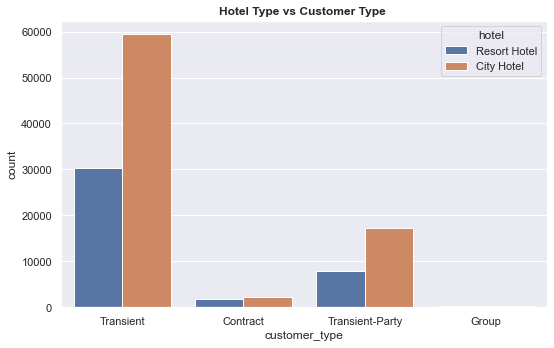

In [33]:
#countplot based on Canceled Situation and Deposit Type column
plt.title('Hotel Type vs Customer Type ', weight='bold')
aw= sns.countplot('customer_type', hue='hotel', data=df,orient = 'v')
with_hue(aw,df['customer_type'],4,2)

- Transient means when the booking is not part of a group or contract, and is not associated to other transient booking
- Transient-party is when the booking is transient, but is associated to at least other transient booking
- Contract is when the booking has an allotment or other type of contract associated to it

- Observations here are straight forward

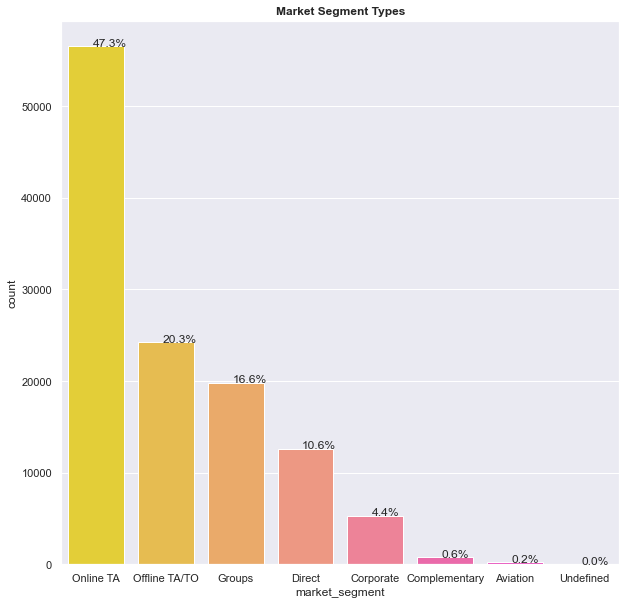

In [36]:
#countplot based on market_segment column

plt.figure(figsize=(10,10))
ax= sns.countplot(df['market_segment'], palette='spring_r', 
              order=pd.value_counts(df['market_segment']).index)
plt.title('Market Segment Types', weight='bold')
without_hue(ax,df['market_segment'])

- The majority of booking were from Travel Agents and Tour Operators, but this may also include corporate because a lot of companies use travel agents to complete bookings. The definition of the data here is ambigious

Text(0.5, 1.0, 'Market Segment Types vs Canceled Situation ')

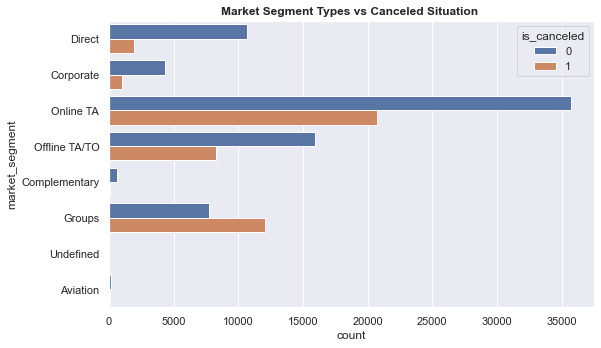

In [37]:
#countplot based on market_segment and is_canceled column
sns.countplot(y='market_segment', hue='is_canceled', data=df)
plt.title('Market Segment Types vs Canceled Situation ', weight='bold')

- highest percentage of cancellations by market segment are group bookings following by offline TA/TO bookings

- It is important to note here that online travel agents have marketing techniques (promos/discounts, etc) and customer acquisition/conversion funnels that may revert some customers from cancelling. On the other hand, customers who booked through offline agents are more inclined to actually cancel the booking since all it takes is a visit or phone call

Text(0.5, 1.0, 'Lead Time vs Market Segment Types')

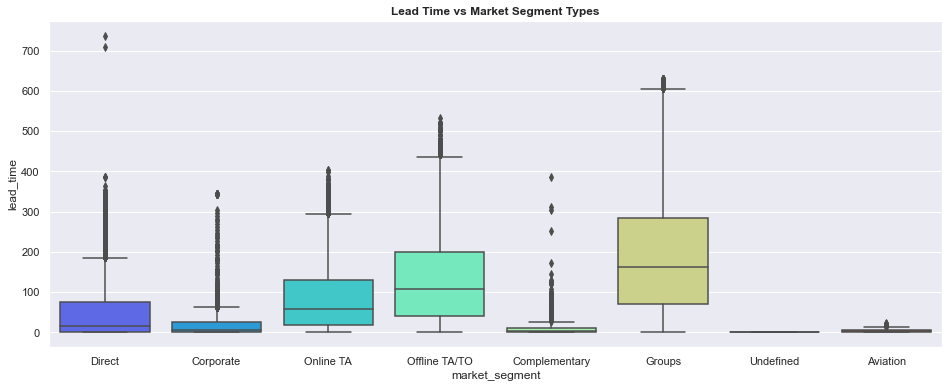

In [39]:
#boxplot based on Market Segment Types and lead_time column

plt.figure(figsize=(16,6))
sns.boxplot(x='market_segment',y='lead_time',data=df,palette='rainbow')
plt.title('Lead Time vs Market Segment Types', weight='bold')

- it is interesting to see that the highest cancellations comes from Groups bookings yet they have the highest lead time

- Also, corporate bookings in general have lower lead time and cancellation 

In [40]:
df['children'].value_counts()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

In [41]:
df['babies'].value_counts()

0     118473
1        900
2         15
10         1
9          1
Name: babies, dtype: int64

defintion of babies and childern is somewhat ambigious so I will do some feature engineering by combining the 2

In [6]:
df['kids']= df['children']+df['babies']

#### I will examine the repeated guests metrics

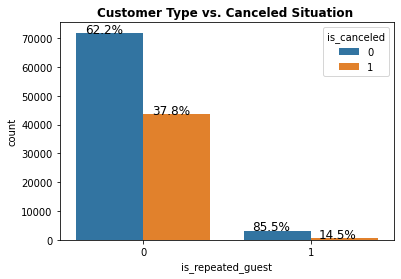

In [9]:
#countplot based on Customer Type and is_cancel column
plt.title('Customer Type vs. Canceled Situation ', weight='bold')
ax=sns.countplot('is_repeated_guest', hue='is_canceled', data=df)
with_hue(ax,df['is_repeated_guest'],2,2)

- as expected, repeated guests have a much lower cancellation rate

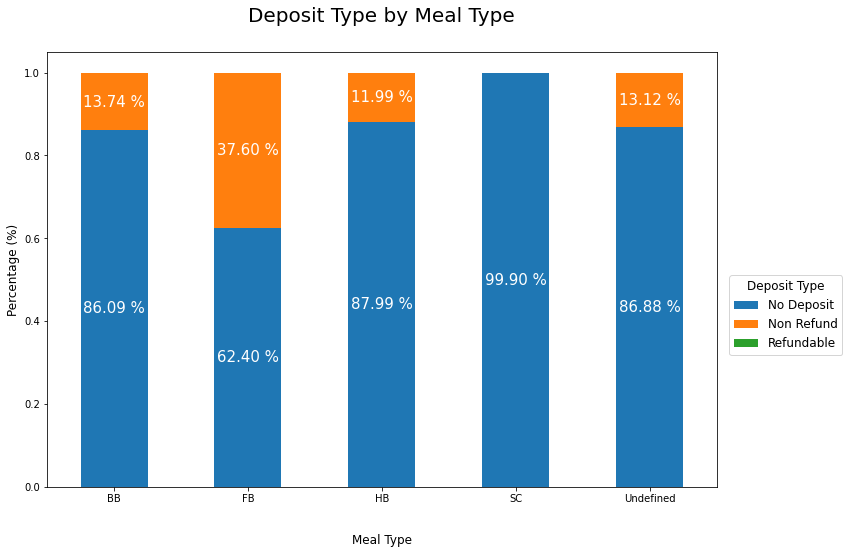

In [30]:
meal_ax3 = pd.crosstab(df['meal'], df['deposit_type'], normalize = 'index').plot.bar(stacked=True, figsize=(12,8))
plt.legend(bbox_to_anchor=(1.01, 0.5), title='Deposit Type', fontsize=12, title_fontsize=12)

j = 1
for p in meal_ax3.patches:
      if j < 9 or j == 10: 
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        meal_ax3.text(x+width/2, 
                y+height/2, 
                '{:.2f} %'.format(height*100), 
                horizontalalignment='center', 
                verticalalignment='center',
                color='white',
                fontsize=15)
      j += 1

plt.title('Deposit Type by Meal Type', fontsize=20, pad=30)    
plt.xticks(rotation=360)
plt.xlabel('Meal Type', fontsize=12, labelpad=30)
plt.ylabel('Percentage (%)', fontsize=12)
plt.show()

- Hotel booking with FB meal plan (Full board: breakfast, lunch and dinner) has the highest cancellation rate compared to other meal plans

- The reason for that is FB have a higher non-refund type deposit ratio and we saw in previous insights that on-refund has a high cancellation rate

One thing I observed from summary statstics is that ADR has some negative values. I will go ahead and disect this feature

In [12]:
df['adr'].describe()

count    119390.000000
mean        101.831122
std          50.535790
min          -6.380000
25%          69.290000
50%          94.575000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

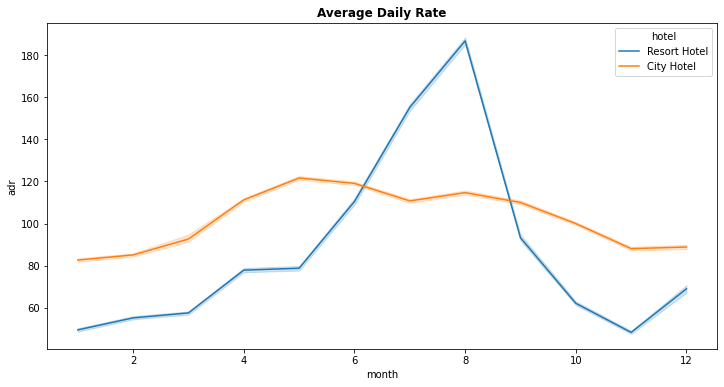

In [46]:
# Average daily rate

plt.figure(figsize=(12,6))
sns.lineplot(x='month', y='adr', hue='hotel', data= df)
plt.title('Average Daily Rate', weight='bold')
plt.show()

The ADR is calculated by dividing the sum of all lodging transactions by the total number of staying nights. Since we have negative values, this could indicate either data reporting errors or data quality issues. 

##### Thus, I will go ahead and drop the negative values

### Step 2: Data Cleaning and Feature Engineering

In [10]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
year                                   0
arrival_date_month                     0
arrival_date_week_number               0
day                                    0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [11]:
df[df['adr']<0]

,hotel,is_canceled,lead_time,year,arrival_date_month,arrival_date_week_number,day,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,month,stays_total,kids,arrival_date
14969,Resort Hotel,0,195,2017,March,10,5,4,6,2,...,Transient-Party,-6.38,0,0,Check-Out,2017-03-15,3,10,0.0,2017-03-05


In [7]:
df=df[df['adr']>0]

In [8]:
#drop column agent and company due to high missing values also reservation_status and arrival_date_week_number since they're useless
df=df.drop(['agent','company','reservation_status','arrival_date_week_number'],axis=1)

For the childern and kids columns, I will fill the missing values with 0 since they were missing (assuming that the customers left it blank because they have no kids)

In [9]:
# filling the missing value
df['children'] =  df['children'].fillna(0)
df['kids'] =  df['kids'].fillna(0)

In [12]:
# dropping the null value rows of country because country is an important predictor
df.dropna(subset=['country'],inplace=True)

In [10]:
# reservation status date is of little relevance as well, so we will drop that column
df=df.drop('reservation_status_date', axis = 1)

In [13]:
df['stays_total']= df['stays_in_week_nights']+df['stays_in_weekend_nights']

I want to analyze 'assigned_room_type' and 'reserved_room_type' columns, but code of room type reserved. Code is presented instead of designation for anonymity reasons. Thus, those features will be included in the model, but no EDA will be done

In [14]:
# check if assigned room type is same as reserved room type
def same_room_type(x):
    if x['reserved_room_type'] == x['assigned_room_type']:
        return 1
    return 0
df['same_room_type'] = df.apply(same_room_type, axis=1)

In [15]:
#encode hotel column
df['is_cityhotel']=df["hotel"].apply(lambda x: 1 if x== 'City Hotel' else 0)
df= df.drop('hotel',axis=1)
df.head()

,is_canceled,lead_time,year,arrival_date_month,day,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,month,arrival_date,stays_total,kids,same_room_type,is_cityhotel
2,0,7,2015,July,1,0,1,1,0.0,0,...,Transient,75.0,0,0,7,2015-07-01,1,0.0,0,0
3,0,13,2015,July,1,0,1,1,0.0,0,...,Transient,75.0,0,0,7,2015-07-01,1,0.0,1,0
4,0,14,2015,July,1,0,2,2,0.0,0,...,Transient,98.0,0,1,7,2015-07-01,2,0.0,1,0
5,0,14,2015,July,1,0,2,2,0.0,0,...,Transient,98.0,0,1,7,2015-07-01,2,0.0,1,0
6,0,0,2015,July,1,0,2,2,0.0,0,...,Transient,107.0,0,0,7,2015-07-01,2,0.0,1,0


In [16]:
# encode categorical variables
labelencoder = LabelEncoder()
df['meal'] = labelencoder.fit_transform(df['meal'])
df['market_segment']= labelencoder.fit_transform(df['market_segment'])
df['distribution_channel']= labelencoder.fit_transform(df['distribution_channel'])
df['reserved_room_type'] = labelencoder.fit_transform(df['reserved_room_type'])
df['assigned_room_type'] = labelencoder.fit_transform(df['assigned_room_type'])
df['deposit_type'] = labelencoder.fit_transform(df['deposit_type'])
df['customer_type']= labelencoder.fit_transform(df['customer_type'])
df['country']= labelencoder.fit_transform(df['country'])

#### Correlation matrix to see correlated variables

Text(0.5, 1.0, 'df.corr()')

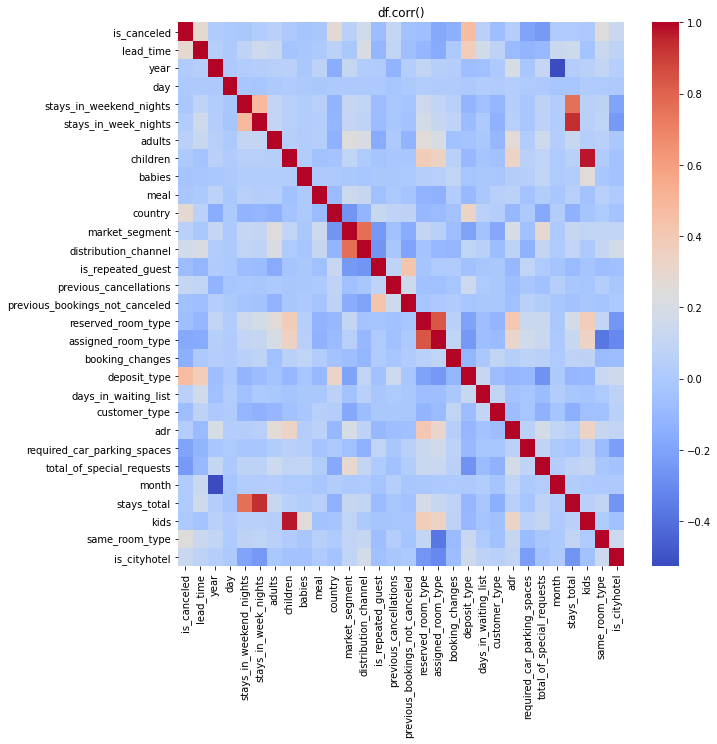

In [17]:
# finding high correlated variables
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cmap='coolwarm')
plt.title('df.corr()')

- Distribution_channel, childern, babies, stay in weekend nights and week nights are highly correlated so I will go ahead and drop them since they won't impact our predictive power in either case

In [18]:
# drop distribution channel keep market segment column
df=df.drop(['distribution_channel','children','babies','stays_in_weekend_nights','stays_in_week_nights'],axis=1)

In [20]:
# convert arrival date to day of week, drop arrival date.
df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['arrival_day_of_week'] = df['arrival_date'].dt.dayofweek
df=df.drop(['arrival_date','arrival_date_month','month','day','year'], axis = 1)

In [27]:
df.head()

,is_canceled,lead_time,adults,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,stays_total,kids,same_room_type,is_cityhotel,arrival_day_of_week
2,0,7,1,0,59,3,0,0,0,0,...,0,2,75.0,0,0,1,0.0,0,0,2
3,0,13,1,0,59,2,0,0,0,0,...,0,2,75.0,0,0,1,0.0,1,0,2
4,0,14,2,0,59,6,0,0,0,0,...,0,2,98.0,0,1,2,0.0,1,0,2
5,0,14,2,0,59,6,0,0,0,0,...,0,2,98.0,0,1,2,0.0,1,0,2
6,0,0,2,0,135,3,0,0,0,2,...,0,2,107.0,0,0,2,0.0,1,0,2


I will export the cleaned data and start a new notebook that includes my predictive modeling

In [28]:
df.to_csv('Cleaned df.csv')